In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PINGU.importer import *
from PINGU.processer import *
from PINGU.main import get_all_events,get_events
from functions import perform_chisq, dc_params_nsi, dc_params
from DC.event_processing import list_of_params_nsi
from PINGU.event_processing import return_precomputed_nsi, get_deltachi, to_hist
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [6]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
precomputed_events = True


dm31_range = np.linspace(2.489*1e-3,2.543*1e-3,2)
th23_range = np.linspace(48*np.pi/180,50.1*np.pi/180,2)
emm_range = np.linspace(-7.5e-2,7.5e-2,3)
emt_range = np.linspace(-1e-2,1e-2,3)


nsi_params = nufit_params_nsi.copy()

# We want to marg over best-fit points too, so insert them
if nsi_params['dm_31'] not in dm31_range:
    dm31_range = np.sort(np.append(dm31_range,nsi_params['dm_31']))
if nsi_params['theta_23'] not in th23_range:
    th23_range = np.sort(np.append(th23_range, nsi_params['theta_23']))
if nsi_params['e_mm'] not in emm_range:
    emm_range = np.sort(np.append(emm_range, nsi_params['e_mm']))
if nsi_params['e_mt'] not in emt_range:
    emt_range = np.sort(np.append(emt_range, nsi_params['e_mt']))

param_list = list_of_params_nsi(nsi_params, dm31_range, th23_range,emm_range, emt_range)

In [7]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    data_H1 = [(p, pid,True) for p in param_list]
    data_H0 = [(Ebin,zbin,param_list[0],pid,False) for Ebin in range(8) for zbin in range(8)]
    p = Pool()
    H1_events_list = p.starmap(get_all_events, data_H1)
    #H0_events = p.starmap(get_events, data_H0)
    p.close()
    #H0_events = np.array(H0_events).reshape(8,8)
    pickle.dump(H1_events_list,open(f'./pre_computed/H1_PINGU_{pid}_{len(dm31_range)}x{len(th23_range)}x{len(emm_range)}x{len(emt_range)}.p','wb'))
    #pickle.dump(H0_events,open(f'./pre_computed/H0_PINGU_{pid}.p','wb'))


H1_list = [pickle.load(open(f'./pre_computed/H1_PINGU_{pid}_{len(dm31_range)}x{len(th23_range)}x{len(emm_range)}x{len(emt_range)}.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_PINGU_{pid}.p','rb')) for pid in [0,1]]
H1 = np.array(H1_list)*livetime
H0 = np.array(H0_list)*livetime
H1 = np.swapaxes(H1,0,1)


'''
no_osc = np.array([get_all_events(params=param_list[0], pid=0, nsi=True, no_osc=True),get_all_events(params=param_list[0], pid=1, nsi=True, no_osc=True)])
no_osc_paper = np.array([no_osc2018_DC(0)[1].values,no_osc2018_DC(1)[1].values])
H0_paper = np.array([pd.read_csv('./src/data/files/DC/2018/cascade_H0.csv', header=None)[1].values,pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values])
events = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_events'),get_hist(events2018_DC().query(f'pid==1'), 'count_events')])
background = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_background'), get_hist(events2018_DC().query(f'pid==1'), 'count_background')])
best_fit_contamination = 0.055/(np.sum(background,axis=(1,2))/np.sum(events,axis=(1,2))) #table 1 DC2017

data = np.sum(events,axis=2)

H0_factors = H0_paper / np.sum(H0,axis=2)
noosc_factors = (no_osc_paper - back_factor.reshape(-1,1)*np.sum(background,axis=2)) / (np.sum(no_osc,axis=2)*livetime) #can laos use best_fit_contamination here

# Normalize NSI hypothesis
H1_nonorm = H1 #No normalization
H1_norm_H0 = H1 * H0_factors[None,:,None,:] #Norm against H0
H1_norm_noosc = H1*noosc_factors[None,:,None,:] # Norm against no oscillation
'''

"\nno_osc = np.array([get_all_events(params=param_list[0], pid=0, nsi=True, no_osc=True),get_all_events(params=param_list[0], pid=1, nsi=True, no_osc=True)])\nno_osc_paper = np.array([no_osc2018_DC(0)[1].values,no_osc2018_DC(1)[1].values])\nH0_paper = np.array([pd.read_csv('./src/data/files/DC/2018/cascade_H0.csv', header=None)[1].values,pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values])\nevents = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_events'),get_hist(events2018_DC().query(f'pid==1'), 'count_events')])\nbackground = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_background'), get_hist(events2018_DC().query(f'pid==1'), 'count_background')])\nbest_fit_contamination = 0.055/(np.sum(background,axis=(1,2))/np.sum(events,axis=(1,2))) #table 1 DC2017\n\ndata = np.sum(events,axis=2)\n\nH0_factors = H0_paper / np.sum(H0,axis=2)\nnoosc_factors = (no_osc_paper - back_factor.reshape(-1,1)*np.sum(background,axis=2)) / (np.sum(no_osc,axi

In [8]:
sigma_a = 0.25
sigma_b = 0.04
f = 0
chisq,  best_fit_index = get_deltachi([H for H in H1],H0,0,[sigma_a,sigma_b],f,x0=[1,0])

reshaped_chisq = chisq.reshape(len(dm31_range), len(th23_range), len(emm_range), len(emt_range))
minimum_ax_2_and_3 = np.min(reshaped_chisq,axis=(2,3)).reshape(len(dm31_range),len(th23_range),1,1)
deltachi = reshaped_chisq - minimum_ax_2_and_3


best_emt_index, best_emm_index,best_th23_index, best_dm31_index = np.unravel_index(np.argmin(chisq),deltachi.shape) #Order is reversed because unravel starts from right
best_dm31, best_th23, best_emm, best_emt = dm31_range[best_dm31_index], th23_range[best_th23_index],emm_range[best_emm_index],emt_range[best_emt_index]

marginalized_deltachi = deltachi[best_dm31_index, best_th23_index]

In [16]:
marginalized_deltachi

array([[2.79737852, 3.51160466, 4.91647597],
       [0.61489873, 0.90924009, 1.93286734],
       [0.01751586, 0.        , 0.70991996]])

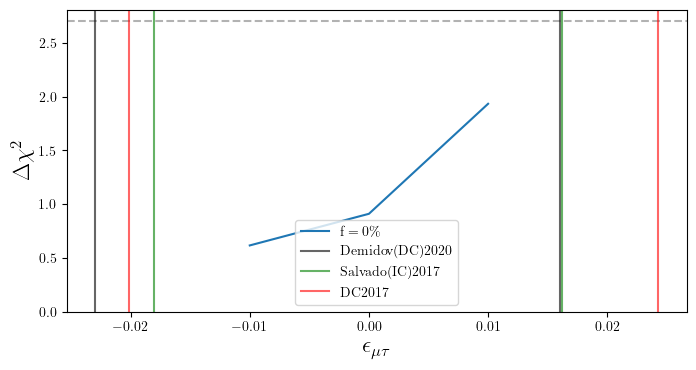

In [15]:
salvado = (-6e-3*3, 5.4e-3*3)
dc_2017 = (-6.7e-3*3, 8.1e-3*3)
demidov = (-0.023, 0.016)
plt.plot(emt_range, marginalized_deltachi[best_emm_index],label=r'$\mathrm{f = 0\%}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov[0], alpha=0.6,c='black', label=r'$\mathrm{Demidov (DC) 2020}$')
plt.axvline(demidov[1], alpha=0.6,c='black')

plt.axvline(salvado[0], alpha=0.6,c='green', label=r'$\mathrm{Salvado (IC) 2017}$')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label=r'$\mathrm{DC 2017}$')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
plt.axvline(salvado[1], alpha=0.6,c='green')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\epsilon_{\mu\tau}$', fontsize=17)
plt.ylabel(r'$\Delta \chi^2$', fontsize=17)
plt.legend()

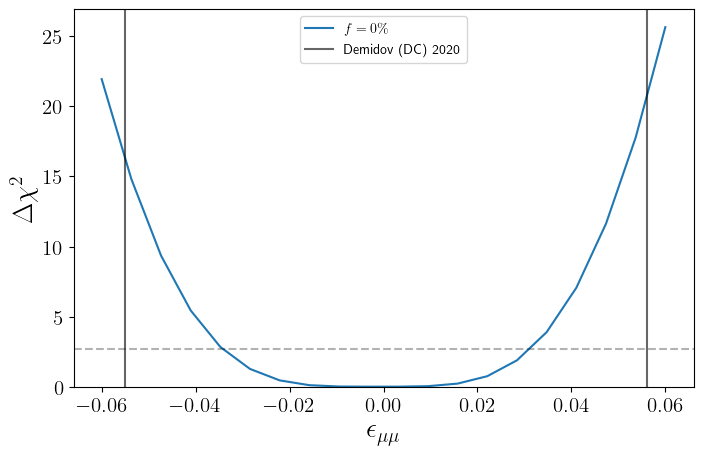

In [56]:
demidov = (-0.055, 0.056)
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(emm_range, deltachi,label=r'$f = 0\%$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov[0], alpha=0.6,c='black', label=r'Demidov (DC) 2020')
plt.axvline(demidov[1], alpha=0.6,c='black')


#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\epsilon_{\mu\mu}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
fig.savefig('./latex/article/figures/PINGU_emm.pdf')

<ipython-input-8-07a609cba45d>:3: UserWarning: The following kwargs were not used by contour: 'label'
  no_err = ax.contour(deltachi.T,levels = [chi2.ppf(q=0.9, df = 2)], label='No exp. uncert.')
<ipython-input-8-07a609cba45d>:4: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  five_err = ax.contour(deltachi1.T,levels = [chi2.ppf(q=0.9, df = 2)], label='5 \% exp. uncert.', color='orange')
<ipython-input-8-07a609cba45d>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels(labels=np.round(emt_range,3))
<ipython-input-8-07a609cba45d>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_yticklabels(labels=np.round(emm_range,3))


<a list of 2 text.Text objects>

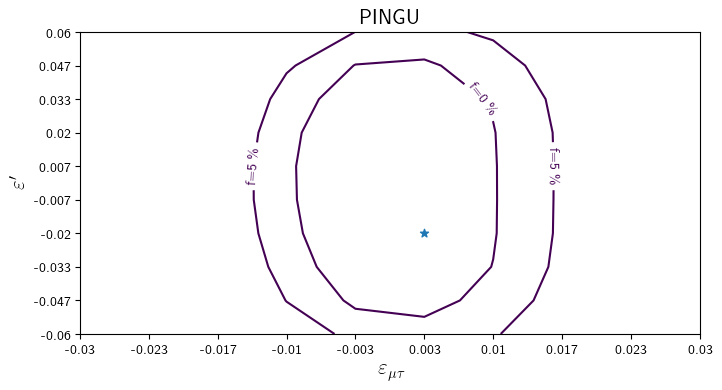

In [8]:
best_fit_coords = np.unravel_index(best_fit_index,(len(emm_range),len(emt_range)))
fig, ax = plt.subplots(1,1, figsize=(8,4))
no_err = ax.contour(deltachi.T,levels = [chi2.ppf(q=0.9, df = 2)], label='No exp. uncert.')
five_err = ax.contour(deltachi1.T,levels = [chi2.ppf(q=0.9, df = 2)], label='5 \% exp. uncert.', color='orange')
ax.scatter(best_fit_coords[0],best_fit_coords[1], marker='*')
_=ax.set_xticklabels(labels=np.round(emt_range,3))
_=ax.set_yticklabels(labels=np.round(emm_range,3))
ax.set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\varepsilon^\prime$', fontsize=15)
plt.title(r'PINGU', fontsize=15)


fmt_noerr = {}
strs = ['f=0 \%']#,'f = 5 \%']
for l, s in zip(no_err.levels, strs):
    fmt_noerr[l] = s

fmt_fiverr = {}
strs = ['f=5 \%']
for l, s in zip(five_err.levels, strs):
    fmt_fiverr[l] = s

ax.clabel(no_err, no_err.levels, inline=True, fmt=fmt_noerr, fontsize=10)
ax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)

"\nfig.savefig('latex/article/figures/PINGU_event_pulls.pdf')\nfrom subprocess import call \n_ = call('pdfcrop latex/article/figures/PINGU_event_pulls.pdf latex/article/figures/PINGU_event_pulls.pdf')\n"

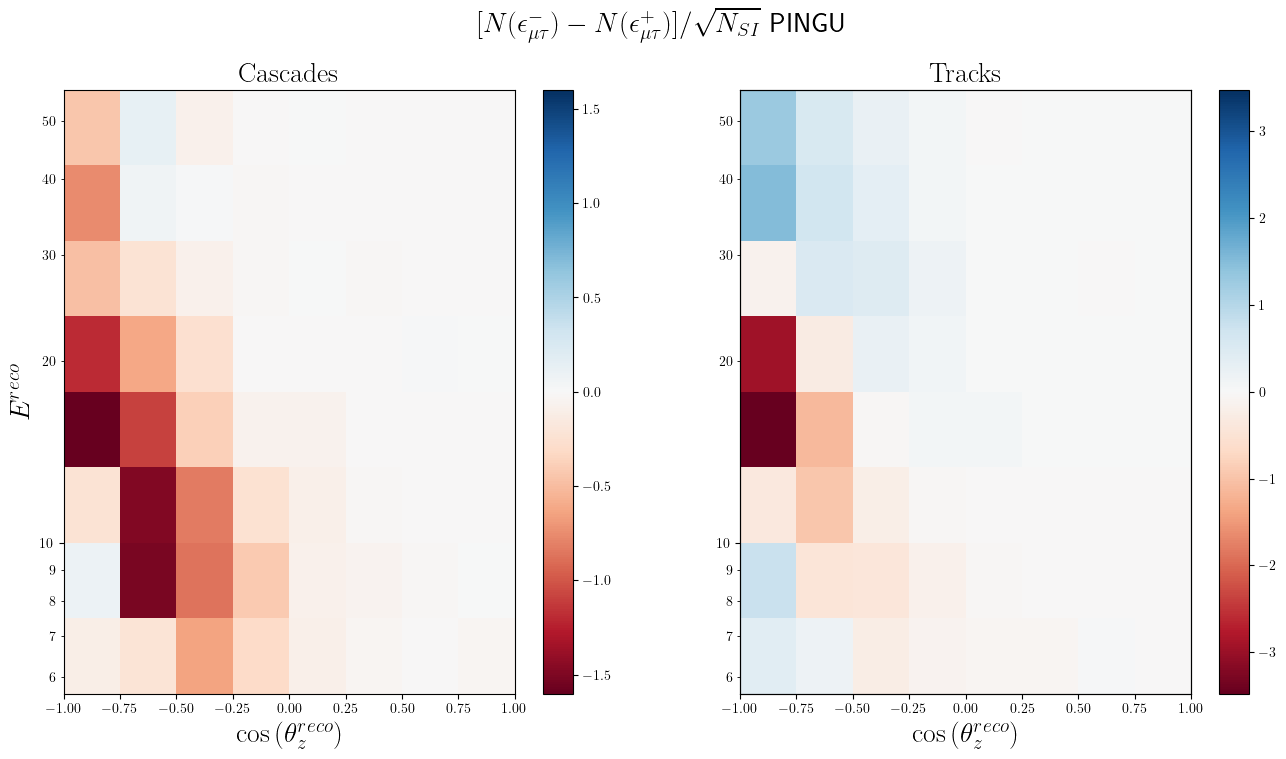

In [20]:
from matplotlib.colors import CenteredNorm
N_NSI_left = H1[0]
N_NSI_right = H1[-1]
N_SI = H0
pull_min = (N_SI - N_NSI_left)/np.sqrt(N_SI)
pull_max = (N_SI - N_NSI_right)/np.sqrt(N_SI)
pull_diff = (N_NSI_left - N_NSI_right)/np.sqrt(N_SI)

titles = [r'$\mathrm{Cascades}$', r'$\mathrm{Tracks}$']
fig, ax = plt.subplots(1,2,figsize=(16,8))
for pid in [0,1]:
    ax[pid].set_title(titles[pid], fontsize=20)
    im = ax[pid].pcolormesh(zbins_2018,Ebins_2018, pull_diff[pid], cmap='RdBu', norm= CenteredNorm(0))
    ax[pid].set_yscale('log')
    plt.colorbar(im, ax=ax[pid])
    ax[pid].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
    
    ax[pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[pid].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #ax[pid].ticklabel_format(style='sci',axis='y')
    #ax[pid].tick_params(which='both',labelsize=13)
    ax[pid].set_yticks([10])
ax[0].set_ylabel(r'$E^{reco}$', fontsize=20)
ax2 = ax[1].twinx()
ax2.set_yticks([])
#ax2.set_ylabel(r'$(N_{SI} - N_{NSI})/\sqrt{N_{SI}}$', fontsize=15, labelpad= 70)
plt.suptitle(r'$[N(\epsilon_{\mu\tau}^-) - N(\epsilon_{\mu\tau}^+)]/\sqrt{N_{SI}}$',fontsize=20)
'''
fig.savefig('latex/article/figures/PINGU_event_pulls.pdf')
from subprocess import call 
_ = call('pdfcrop latex/article/figures/PINGU_event_pulls.pdf latex/article/figures/PINGU_event_pulls.pdf')
'''